In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('@,@')

@,@


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised = True,
)
print('@,@')

@,@


### train dataset 눈으로 확인해보기

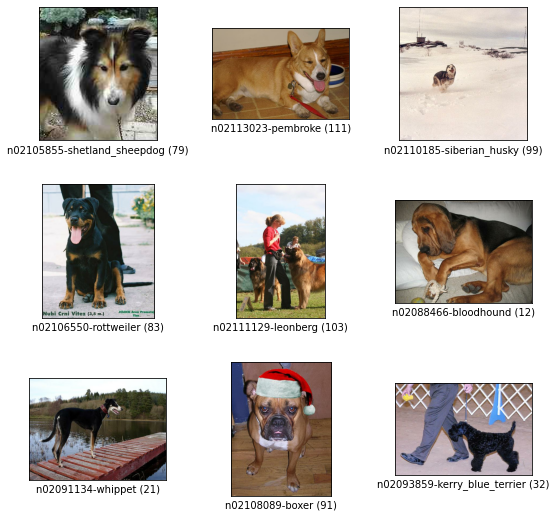

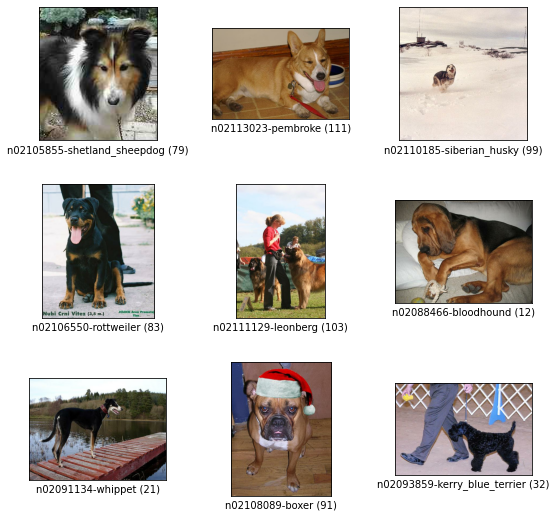

In [17]:
tfds.show_examples(ds_train, ds_info)

### test dataset 눈으로 확인해보기

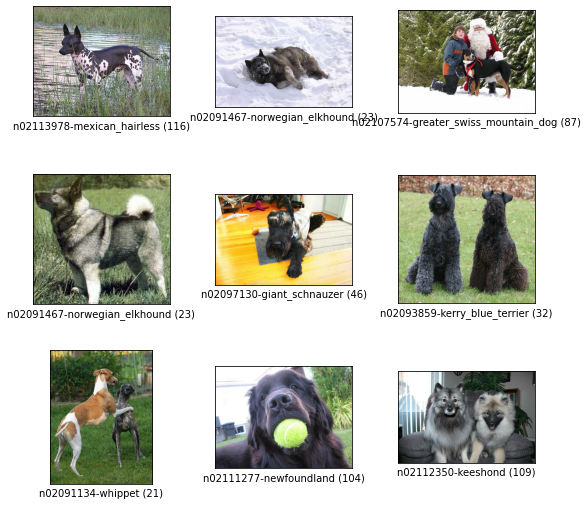

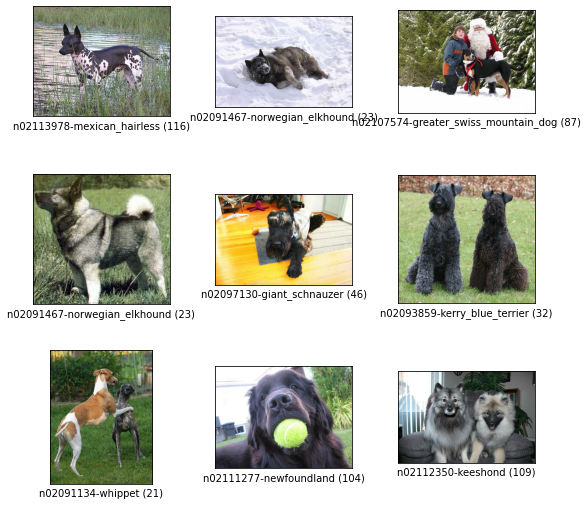

In [18]:
tfds.show_examples(ds_test, ds_info)

### 데이터셋의 구성

In [19]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [20]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls= 2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('@,@')

@,@


In [21]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [22]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',# GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax', name = 'predictions')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [23]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


In [24]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 166s 211ms/step - loss: 2.2539 - accuracy: 0.4317 - val_loss: 3.0687 - val_accuracy: 0.2418
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 0.6518 - accuracy: 0.8256 - val_loss: 1.5494 - val_accuracy: 0.5696
Epoch 3/20
750/750 [==============================] - 159s 211ms/step - loss: 0.1717 - accuracy: 0.9747 - val_loss: 1.0788 - val_accuracy: 0.6904
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0545 - accuracy: 0.9973 - val_loss: 0.9768 - val_accuracy: 0.7215
Epoch 5/20
750/750 [==============================] - 158s 211ms/step - loss: 0.0287 - accuracy: 0.9987 - val_loss: 0.9753 - val_accuracy: 0.7253
Epoch 6/20
750/750 [==============================] - 159s 211ms/step - loss: 0.0188 - accuracy: 0.9996 - val_loss: 1.0027 - val_accuracy: 0.7232
Epoch 7/20
750/750 [==============================] - 159s 211ms/step - loss: 0.0132 - accuracy: 0.9998 - val_loss: 0.9793 -

In [25]:
# Q. '/aiffel/class_activation_map' 에 'cam_model1.h5'을 저장하세요.

import os

cam_model_path = '/aiffel/GoingDeeper/class_activation_map/cam_model.h5'

# 모델을 'cam_model.h5'로 저장
cam_model.save(cam_model_path)

print(f'Model saved at: {cam_model_path}')


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saved at: /aiffel/GoingDeeper/class_activation_map/cam_model.h5


# CAM

In [4]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('@,@')

@,@


In [5]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


46


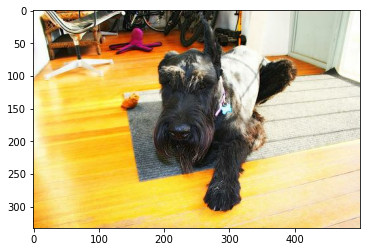

In [28]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [9]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/GoingDeeper/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [40]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # cam model 재설정
    # -3인 이유는 -1이 Dense layer -2가 GAP layer, -3이 마지막 Conv layer이기 때문에
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    # 맨 앞에 열을 추가해 배치사이즈 정보도 넣어 cam_model을 돌린다
    conv_outputs, preds = cam_model(tf.expand_dims(img_tensor,0))
    # Resnet50을 썼으므로 마지막 conv output shape은 (1,7,7,2048)로 예상된다
    # shape이 (7,7,2048)로 바꿔서 사용해주기
    conv_outputs = conv_outputs[0,:,:,:]
    
    # fully connected layer 층에서 각 클래스에 대한 weight activation 값들이 생성됨
    # 따라서 layers[-1]은 마지막 완전 연결층이라는 뜻
    # get_wieghts()[0]은 가중치행렬, get_weights()[1]은 편향벡터를 의미하기 때문에 
    # [0]을 사용해 가중치 행렬만 가져옴.
    class_weights = model.layers[-1].get_weights()[0]
    
    #cam이미지를 만들 빈 어레이 만들어놓기
    cam_img = np.zeros(shape = conv_outputs.shape[0:2])
    
    # i번째 conv_output 채널들과 각 i번째 가중치값들을 곱해서 
    # 모두 다 더하면 CAM 이미지의 값을 구할 수 있음
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_img += w* conv_outputs[:,:,i]
        
    cam_img /= np.max(cam_img) # 정규화해주기
    cam_img = cam_img.numpy() # numpy화 해주기
    cam_img = cv2.resize(cam_img, (width, height)) # 원래 이미지 크기로 바꿔주기
    return cam_img

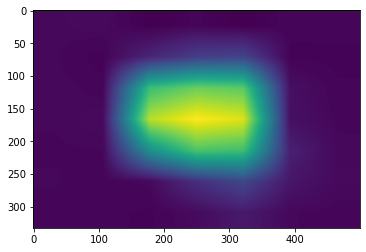

In [31]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [32]:
def visualize_cam_on_image(image, cam_image):
    merged_image = cv2.addWeighted(image,0.3, cam_image, 0.7, 0.0)
    return merged_image

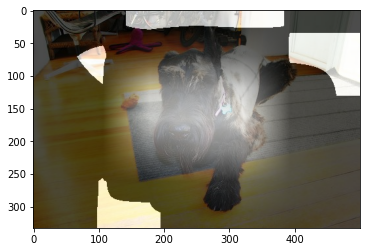

In [33]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(origin_image,cam_image_3channel)
plt.imshow(blended_image)
plt.show()

# Grad-CAM

23


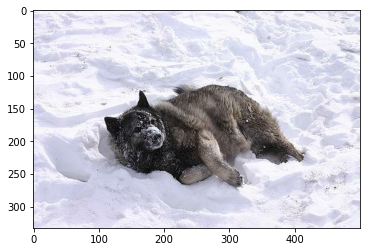

In [10]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [34]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # grad_model 재설정
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # 모든 레이어를 훈련 가능하게 설정
#     for layer in grad_model.layers:
#         layer.trainable = True
        
    # gradient를 얻기위해서
    with tf.GradientTape() as tape:
#       tape.watch(img_tensor)  # watch img_tensor to track operations on it
        
        # tf.expand_dims(img_tensor,0)을 하는 이유:
        # img_tensor에는 width, heigh, channel값만 들어있음.
        #하지만 batch 값도 넣고 model을 돌려야하기 때문에
        conv_last_output, pred = grad_model(tf.expand_dims(img_tensor,0)) 
        
        # loss와 cov_output 구하기
        conv_output = conv_last_output[0] # shape: (7,7,2048)
        loss = pred[:, class_idx] # shape: (1,), class의 예측값
#         # Debugging output
#         print("conv_last_output shape:", conv_last_output.shape)
#         print("pred shape:", pred.shape)
#         print("loss:", loss.numpy())
#         print("conv_output shape:", conv_output.shape)
        grad_val = tape.gradient(loss, conv_last_output) # gradient_value = gradient(target, source)
#         print(grad_val)                      
        if grad_val is None:
            raise ValueError("Gradient calculation failed, check tensor operations.")
        grad_val = grad_val[0]  # gradient의 첫 번째 요소를 선택
    
    weights = np.mean(grad_val, axis = (0,1)) #GAP이용해서 weight구하기
    grad_img = np.zeros(shape = conv_last_output.shape[0:2], dtype = np.float32) # 빈 array 만들어놓기
    # i번째 conv_output채널과 i번째 weight를 곱하고 전부 다 더해서 CAM이미지 얻기
    for i, w in enumerate(weights):
        grad_img += w*conv_output[:,:,i]
        
    grad_img = tf.math.maximum(0, grad_img) # 음수는 전부 0으로 바꿔주는 Relu 써주기
    grad_img /= np.max(grad_img) # 이미지 정규화하기
    grad_img = grad_img.numpy() # tensor를 numpy 형식으로 변환
    grad_img = cv2.resize(grad_img, (width, height)) # 원래 사이즈의 이미지로 바꿔주기
    
    return grad_img
        
    

with tf.GradientTape() as tape:를 쓰는 이유는? <br>
Grad-CAM에서 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 weights로 활용하기 때문.

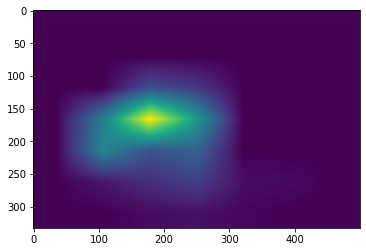

In [35]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

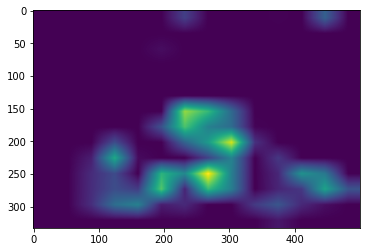

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

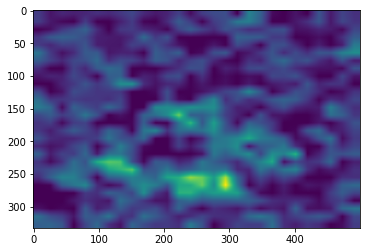

In [37]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

## 바운딩박스구하기

### CAM 바운딩박스

In [116]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image = copy.deepcopy(cam_image)
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('@,@')

@,@


67


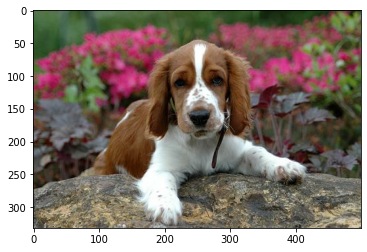

In [125]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

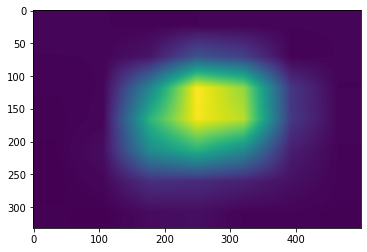

In [126]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [127]:
rect = get_bbox(cam_image)
rect

array([[111,  33],
       [443,  33],
       [443, 294],
       [111, 294]])

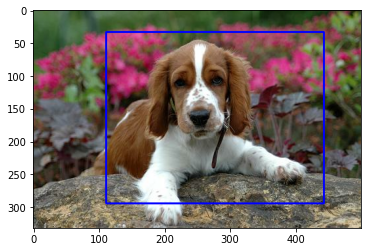

In [128]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Grad-CAM 바운딩박스

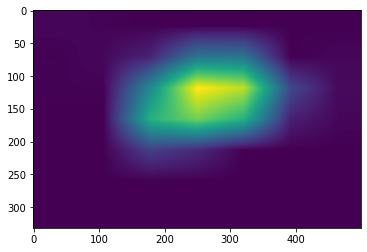

In [129]:
grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [136]:
grad_rect = get_bbox(grad_cam_image, 0.025)
grad_rect

array([[102,  33],
       [458,  15],
       [469, 239],
       [114, 257]])

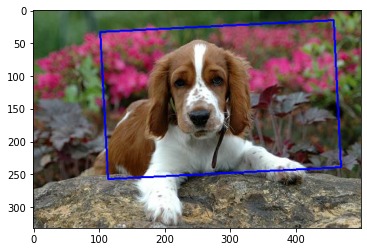

In [137]:
grad_image = copy.deepcopy(item['image'])
grad_image = cv2.drawContours(grad_image, [grad_rect], 0, (0,0,255), 2)
plt.imshow(grad_image)
plt.show()

### GradCam Bounding Box의 문제점

#### ex 1) Grad CAM vs CAM

116


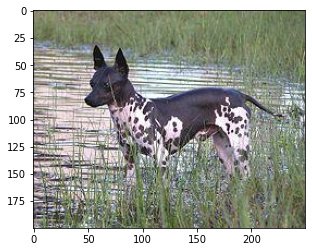

In [214]:
ex = get_one(ds_test)
print(ex['label'])
plt.imshow(ex['image'])
plt.show()

* Grad_CAM

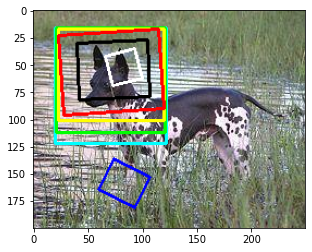

In [256]:
grad_problem = copy.deepcopy(ex['image'])
grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', ex)
#Blue
grad_rect1 = get_bbox(grad_cam_image, 0.025)
grad_problem = cv2.drawContours(grad_problem, [grad_rect1], 0, (0,0,255), 2)
# SkyBlue
grad_rect2 = get_bbox(grad_cam_image, 0.05)
grad_problem = cv2.drawContours(grad_problem, [grad_rect2], 0, (0,255,255), 2)
# Green
grad_rect3 = get_bbox(grad_cam_image, 0.075)
grad_problem = cv2.drawContours(grad_problem, [grad_rect3], 0, (0,255,0), 2)
# Yellow
grad_rect4 = get_bbox(grad_cam_image, 0.1)
grad_problem = cv2.drawContours(grad_problem, [grad_rect4], 0, (255,255,0), 2)
# Red
grad_rect5 = get_bbox(grad_cam_image, 0.2)
grad_problem = cv2.drawContours(grad_problem, [grad_rect5], 0, (255,0,0), 2)
# Black
grad_rect6 = get_bbox(grad_cam_image, 0.5)
grad_problem = cv2.drawContours(grad_problem, [grad_rect6], 0, (0,0,0), 2)
# White
grad_rect7 = get_bbox(grad_cam_image, 0.8)
grad_problem = cv2.drawContours(grad_problem, [grad_rect7], 0, (255,255,255), 2)

plt.imshow(grad_problem)
plt.show()

* CAM

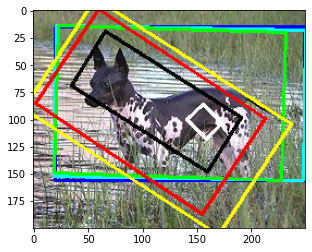

In [259]:
grad_problem = copy.deepcopy(ex['image'])
cam_image1 = generate_cam(cam_model, ex)
#Blue
grad_rect1 = get_bbox(cam_image1, 0.025)
grad_problem = cv2.drawContours(grad_problem, [grad_rect1], 0, (0,0,255), 2)
# SkyBlue
grad_rect2 = get_bbox(cam_image1, 0.05)
grad_problem = cv2.drawContours(grad_problem, [grad_rect2], 0, (0,255,255), 2)
# Green
grad_rect3 = get_bbox(cam_image1, 0.075)
grad_problem = cv2.drawContours(grad_problem, [grad_rect3], 0, (0,255,0), 2)
# Yellow
grad_rect4 = get_bbox(cam_image1, 0.1)
grad_problem = cv2.drawContours(grad_problem, [grad_rect4], 0, (255,255,0), 2)
# Red
grad_rect5 = get_bbox(cam_image1, 0.2)
grad_problem = cv2.drawContours(grad_problem, [grad_rect5], 0, (255,0,0), 2)
# Black
grad_rect6 = get_bbox(cam_image1, 0.5)
grad_problem = cv2.drawContours(grad_problem, [grad_rect6], 0, (0,0,0), 2)
# White
grad_rect7 = get_bbox(cam_image1, 0.8)
grad_problem = cv2.drawContours(grad_problem, [grad_rect7], 0, (255,255,255), 2)

plt.imshow(grad_problem)
plt.show()

#### ex 2) Grad CAM vs CAM

108


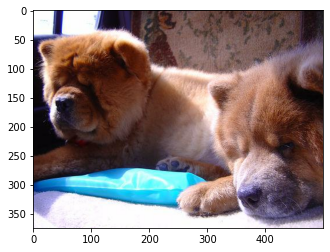

In [220]:
ex2 = get_one(ds_test)
print(ex2['label'])
plt.imshow(ex2['image'])
plt.show()

* Grad_CAM

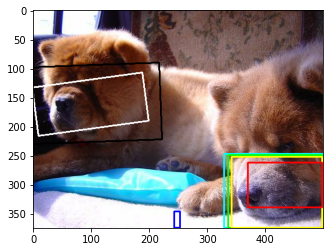

In [260]:
grad_problem2 = copy.deepcopy(ex2['image'])
grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', ex2)
# Blue
grad_rect1 = get_bbox(grad_cam_image, 0.025)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect1], 0, (0,0,255), 2)
# Skyblue
grad_rect2 = get_bbox(grad_cam_image, 0.05)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect2], 0, (0,255,255), 2)
# Green
grad_rect3 = get_bbox(grad_cam_image, 0.075)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect3], 0, (0,255,0), 2)
# Yellow
grad_rect4 = get_bbox(grad_cam_image, 0.1)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect4], 0, (255,255,0), 2)
# Red
grad_rect5 = get_bbox(grad_cam_image, 0.2)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect5], 0, (255,0,0), 2)
# Black
grad_rect6 = get_bbox(grad_cam_image, 0.5)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect6], 0, (0,0,0), 2)
# White
grad_rect7 = get_bbox(grad_cam_image, 0.8)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect7], 0, (255,255,255), 2)
# # Brown
# grad_rect8 = get_bbox(grad_cam_image, 0.01)
# grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect8], 0, (225,125,0), 2)
plt.imshow(grad_problem2)
plt.show()

* CAM

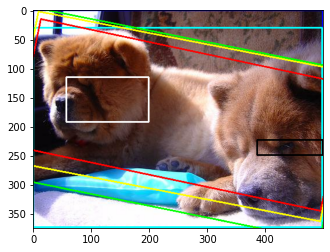

In [261]:
grad_problem2 = copy.deepcopy(ex2['image'])
cam_image2 = generate_cam(cam_model, ex2)
# Blue
grad_rect1 = get_bbox(cam_image2, 0.025)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect1], 0, (0,0,255), 2)
# Skyblue
grad_rect2 = get_bbox(cam_image2, 0.05)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect2], 0, (0,255,255), 2)
# Green
grad_rect3 = get_bbox(cam_image2, 0.075)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect3], 0, (0,255,0), 2)
# Yellow
grad_rect4 = get_bbox(cam_image2, 0.1)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect4], 0, (255,255,0), 2)
# Red
grad_rect5 = get_bbox(cam_image2, 0.2)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect5], 0, (255,0,0), 2)
# Black
grad_rect6 = get_bbox(cam_image2, 0.5)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect6], 0, (0,0,0), 2)
# White
grad_rect7 = get_bbox(cam_image2, 0.8)
grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect7], 0, (255,255,255), 2)
# # Brown
# grad_rect8 = get_bbox(grad_cam_image, 0.01)
# grad_problem2 = cv2.drawContours(grad_problem2, [grad_rect8], 0, (225,125,0), 2)
plt.imshow(grad_problem2)
plt.show()

#### ex 3) Grad CAM vs CAM

84


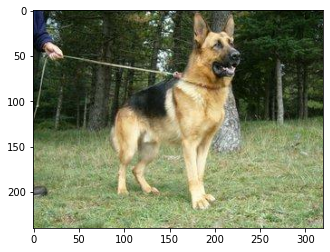

In [251]:
ex3 = get_one(ds_test)
print(ex3['label'])
plt.imshow(ex3['image'])
plt.show()

* Grad_CAM

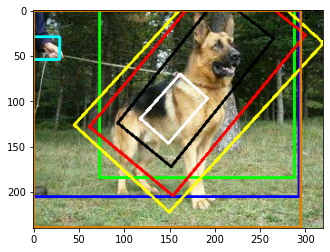

In [262]:
grad_problem3 = copy.deepcopy(ex3['image'])
grad_cam_image = generate_grad_cam(cam_model,'conv5_block3_out', ex3)
# Blue
grad_rect1 = get_bbox(grad_cam_image, 0.025)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect1], 0, (0,0,255), 2)
# Skyblue
grad_rect2 = get_bbox(grad_cam_image, 0.05)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect2], 0, (0,255,255), 2)
# Green
grad_rect3 = get_bbox(grad_cam_image, 0.075)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect3], 0, (0,255,0), 2)
# Yellow
grad_rect4 = get_bbox(grad_cam_image, 0.1)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect4], 0, (255,255,0), 2)
# Red
grad_rect5 = get_bbox(grad_cam_image, 0.2)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect5], 0, (255,0,0), 2)
# Black
grad_rect6 = get_bbox(grad_cam_image, 0.5)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect6], 0, (0,0,0), 2)
# White
grad_rect7 = get_bbox(grad_cam_image, 0.8)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect7], 0, (255,255,255), 2)
# # Brown
grad_rect8 = get_bbox(grad_cam_image, 0.01)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect8], 0, (225,125,0), 2)
plt.imshow(grad_problem3)
plt.show()

* CAM

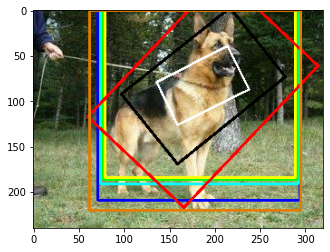

In [263]:
grad_problem3 = copy.deepcopy(ex3['image'])
cam_image3 = generate_cam(cam_model, ex3)
# Blue
grad_rect1 = get_bbox(cam_image3, 0.025)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect1], 0, (0,0,255), 2)
# Skyblue
grad_rect2 = get_bbox(cam_image3, 0.05)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect2], 0, (0,255,255), 2)
# Green
grad_rect3 = get_bbox(cam_image3, 0.075)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect3], 0, (0,255,0), 2)
# Yellow
grad_rect4 = get_bbox(cam_image3, 0.1)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect4], 0, (255,255,0), 2)
# Red
grad_rect5 = get_bbox(cam_image3, 0.2)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect5], 0, (255,0,0), 2)
# Black
grad_rect6 = get_bbox(cam_image3, 0.5)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect6], 0, (0,0,0), 2)
# White
grad_rect7 = get_bbox(cam_image3, 0.8)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect7], 0, (255,255,255), 2)
# # Brown
grad_rect8 = get_bbox(cam_image3, 0.01)
grad_problem3 = cv2.drawContours(grad_problem3, [grad_rect8], 0, (225,125,0), 2)
plt.imshow(grad_problem3)
plt.show()

* 문제점<br>
    * Grad-CAM이 구조적으로나 성능적으로 CAM보다 더 나은 결과물을 가져온다고 알고있었는데 그렇지 못하다는 것을 알게되었다.
    * ex1 grad cam 그림에서 파란사각형, ex2 grad cam 그림에서 파란사각형, ex3 grad cam 그림에서 하늘색사각형을 보면 알 수 있듯이 작은 threshold를 넣은 것들에서 강아지가 아닌 아예 다른 것을 선택하는 경향이 보여졌다.
    * ex2 grad cam과 cam을 비교해보면 cam에서는 두마리 강아지를 한꺼번에 잡지만 gradcam에서는 하나씩만 잡는 것을 알 수 있었다.
    
따라서 Grad CAM의 코드를 더 나은 코드로 만들 수 있는 방법을 생각해봐야할 것 같다.

### Original, CAM, Grad_CAM의 바운딩 시각화

In [151]:
def minmax_to_rect(bbox, image):
    y_min = int(bbox[0,0]*image.shape[0]) #Top left corner
    x_min = int(bbox[0,1]*image.shape[1]) #Top-right corner
    y_max = int(bbox[0,2]*image.shape[0]) #Bottom-right corner
    x_max = int(bbox[0,3]*image.shape[1]) #Bottom-left corner
    
    rect = np.array([
        [x_min, y_min],
        [x_max, y_min],
        [x_max, y_max],
        [x_min, y_max]
    ])
    return rect


In [152]:
original_rect = minmax_to_rect(item['objects']['bbox'],item['image'])

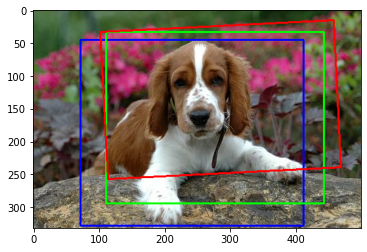

In [158]:
real_image = copy.deepcopy(item['image'])
rea_image = cv2.drawContours(real_image, [original_rect], 0, (0,0,255), 2) # Blue
real_image = cv2.drawContours(real_image, [rect], 0, (0,255,0),2) # Green
real_image = cv2.drawContours(real_image, [grad_rect], 0, (255,0,),2) # Red
plt.imshow(real_image)
plt.show()

* Blue is original bbox
* Green is CAM bbox
* Red is GradCam bbox

### IoU = $\frac{A \cap B}{A \cup B}$

In [141]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('@,@')

@,@


In [161]:
cam_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.222, 0.8855421686746988, 0.886]

In [162]:
grad_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.045180722891566265, 0.204, 0.7740963855421686, 0.938]

In [164]:
original_bbox = item['objects']['bbox'][0]

In [159]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('@,@')

@,@


In [165]:
# original box, CAM box, Grad-CAM box의 iou 구하기
# original과 CAMbox
iou_OC = get_iou(original_bbox, cam_bbox)
iou_OG = get_iou(original_bbox, grad_bbox)
iou_CG = get_iou(cam_bbox, grad_bbox)
print(f'IOU of Original and CAM bbox:{iou_OC}')
print(f'IOU of Original and Grad_CAM bbox:{iou_OG}')
print(f'IOU of CAM and Grad_CAM bbox:{iou_CG}')

IOU of Original and CAM bbox:0.6983858334151163
IOU of Original and Grad_CAM bbox:0.5535759019017126
IOU of CAM and Grad_CAM bbox:0.7356030782013492


## 회고
배운점: CAM과 Grad-CAM의 구조에 대해서 많은 것을 배우게되었습니다.<br>
<br>
아쉬운 점: 그냥 노드에 있던 CAM과 Grad-CAM의 코드를 외워서 따라 만든 것이다보니 정말 제가 만든게 아닌 것 같다는 생각이 들어 너무 아쉬웠습니다. 그리고 노드에 있던 Grad CAM의 문제점을 파악했지만 그 문제를 해결할 Grad-CAM을 만들지 못한것이 아쉽습니다. <br>
<br>
느낀점: 과거 다른 그루분께서 XAI에 대해서 설명하신적이 있었는데 그때는 그냥 막연한 개념이라고 생각했었던 것을 실제로 배우고 활용해보니까 좀 와닿은 것 같아 재밌었습니다.<br>
<br>
어려웠던 점: 아예 CAM과 Grad-CAM을 처음부터 끝까지 만들려고 했을때 조금 막막해서 그냥 노드에서 준 코드를 하나하나 분석했습니다.<br>